In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# שלב 1: טעינת נתונים
train_data = pd.read_csv('KDDTrain+.txt', header=None)
test_data = pd.read_csv('KDDTest+.txt', header=None)


In [10]:
# שלב 2: סיווג התקפות ל-DoS ו-ARP MitM לפי מספרים
def categorize_attack(label):
    dos_attacks = [1, 2, 3, 4, 5, 6, 19, 20]  # התקפות DoS
    arp_attacks = [8, 9, 10, 14, 15, 16, 17]  # התקפות ARP MitM
    if label in dos_attacks:
        return "DoS"
    elif label in arp_attacks:
        return "ARP MitM"
    else:
        return "Other"

# החלת הסיווג
train_data['attack_category'] = train_data.iloc[:, -1].apply(categorize_attack)
test_data['attack_category'] = test_data.iloc[:, -1].apply(categorize_attack)

In [12]:
# שלב 3: קידוד עמודות קטגוריות
categorical_columns = [1, 2, 3]  # protocol_type, service, flag
le = LabelEncoder()
for col in categorical_columns:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

# קידוד התווית
y_train = le.fit_transform(train_data['attack_category'])
y_test = le.transform(test_data['attack_category'])

X_train = train_data.drop(columns=[41, 'attack_category'])
X_test = test_data.drop(columns=[41, 'attack_category'])

In [14]:
# שלב 4: נרמול נתונים
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# שלב 4: בניית מודל Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# שלב 5: הערכת ביצועים
y_pred = rf_model.predict(X_test_scaled)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[ 3813    81   299]
 [  222  2487   143]
 [  799   114 14586]]
Classification Report:
               precision    recall  f1-score   support

    ARP MitM       0.79      0.91      0.84      4193
         DoS       0.93      0.87      0.90      2852
       Other       0.97      0.94      0.96     15499

    accuracy                           0.93     22544
   macro avg       0.90      0.91      0.90     22544
weighted avg       0.93      0.93      0.93     22544

Accuracy: 0.9264549325762953


In [20]:
# שלב 6: שיפור ביצועים באמצעות GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# תוצאות המודל המשופר
y_pred_optimized = grid_search.best_estimator_.predict(X_test_scaled)
print("Optimized Model - Classification Report:\n", classification_report(y_test, y_pred_optimized, target_names=le.classes_))
print("Optimized Accuracy:", accuracy_score(y_test, y_pred_optimized))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Optimized Model - Classification Report:
               precision    recall  f1-score   support

    ARP MitM       0.79      0.94      0.86      4193
         DoS       0.93      0.89      0.91      2852
       Other       0.98      0.94      0.96     15499

    accuracy                           0.93     22544
   macro avg       0.90      0.92      0.91     22544
weighted avg       0.94      0.93      0.94     22544

Optimized Accuracy: 0.934528034066714


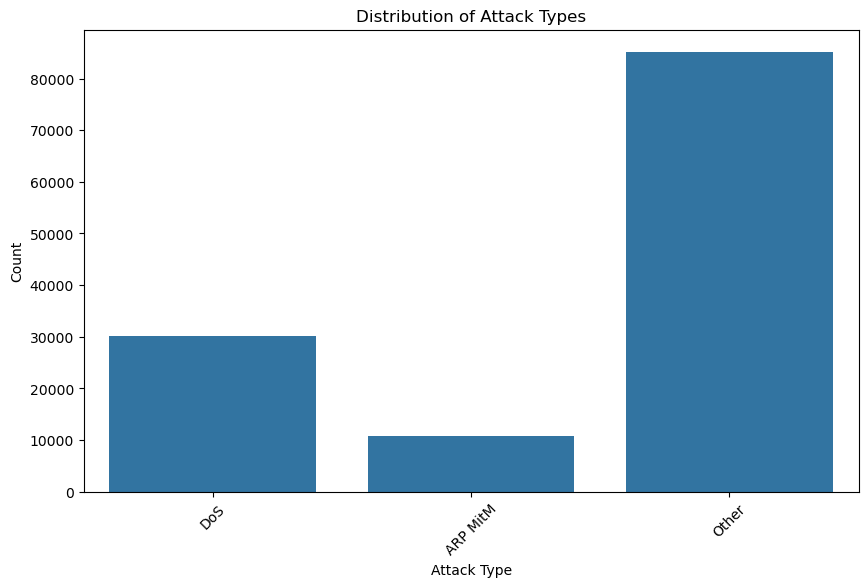

In [21]:
# שלב 7: הצגת התפלגות סוגי התקפות
plt.figure(figsize=(10, 6))
sns.countplot(x=train_data['attack_category'])
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()